In [1]:
# In The Name of God
# Train Adversary for UCI-Adult (private attr: gender, utility attr: income)
# Adversary Determines Gender
# this model can use for extracing gender from obfuscated data as an adversary
# the reverse of accuracy in this term means Privacy.
# Notes:
#      1- Use testset as validation. (ok)
#      2- beta changed to 0.9. (not useful - changed to 0.5)
#      3- Random weight initialization corrected (make training faster - not needded - removed)
#      4- Use Multicategorial BCE (complicated - neglate this)
# changes:
#      V1: 21/10/1401 - base

In [2]:
#@title
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
from collections import OrderedDict
import time

from torch.utils.data import random_split
from math import floor

import torchvision.utils as vutils
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import itertools
import random

import shutil
from zipfile import ZipFile
import os

from IPython.core.debugger import set_trace

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [30]:
# Hyper parameters:
# change lastRunEpochNumber for every run based on saved files
isFirstRun = True
lastRunEpochNumber = 0
manual_seed = 20

learning_rate = 0.001 #0.2
batch_size = 64

files_not_ready = True
dataset_folder_path = 'drive/MyDrive/ML/datasets'

data_dir = 'adult'
save_dir = 'uci-utl-rev2-main'
saving_path = 'drive/MyDrive/ML/saves/' + save_dir + '/'

# Number of workers for dataloader
workers = 2
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Number of training epochs
num_epochs = 20 #10

is_adv = False
if is_adv:
  data_index = 1
else:
  data_index = 2

In [31]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [32]:
# Mount google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# download dataset and unzip

if files_not_ready:
    dataset_csv_path = dataset_folder_path + '/adult.csv'

    try:
      os.mkdir(data_dir)
      print("data folder created successfully")
    except OSError as e:
      print("Error: %s" % (e.strerror))

    shutil.copyfile(dataset_csv_path, data_dir + r'/adult.csv')

try:
    os.mkdir(saving_path)
    print("saving_path directory created successfully")
except OSError as e:
    print("Error: %s" % (e.strerror))

Error: File exists
saving_path directory created successfully


In [34]:
# Define transforms
# train_transforms = transforms.Compose(transforms.ToTensor())
# test_transforms = transforms.Compose(transforms.ToTensor())

In [35]:
#PreProcess dataset:
df = pd.read_csv(os.path.join(data_dir,'adult.csv'))
df = df.replace({'?':np.nan})
df = df.dropna()
df1 = pd.get_dummies(df)
train, test = train_test_split(df1, test_size = 0.2, random_state = 42)
utility_train_true_labels = np.array(train[['income_<=50K','income_>50K']])
utility_test_true_labels = np.array(test[['income_<=50K','income_>50K']])
private_train_true_labels = np.array(train[['gender_Male', 'gender_Female']])
private_test_true_labels = np.array(test[['gender_Male', 'gender_Female']])
x_train = (train.drop(['income_<=50K','income_>50K','gender_Male', 'gender_Female'],axis='columns'))
x_test = (test.drop(['income_<=50K','income_>50K','gender_Male', 'gender_Female'],axis='columns'))
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(x_train)
x_train = standard_scaler.transform(x_train)
x_test = standard_scaler.transform(x_test)


In [36]:
from torch.utils.data import Dataset

class UciAdultDataset(Dataset):
    def __init__(self, X, Y_p, Y_u):#, transform):
        self.X = X
        self.Y_p = Y_p
        self.Y_u = Y_u
        # self.transform = transform
        
    def __len__(self):
        return len(self.Y_p)
    
    def __getitem__(self, idx):
        data = self.X[idx]
        label_p = self.Y_p[idx]
        label_u = self.Y_u[idx]
        data = torch.from_numpy(data)
        label_p = torch.from_numpy(label_p)
        label_u = torch.from_numpy(label_u)
        return data, label_p, label_u

In [37]:
# Load Datas
train_set = UciAdultDataset(x_train, private_train_true_labels, utility_train_true_labels)#, transform=train_transforms)
test_set = UciAdultDataset(x_test, private_test_true_labels, utility_test_true_labels)#, transform=test_transforms)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=workers, drop_last=True)

In [38]:
# Decide which device we want to run on
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [39]:
# custom weights initialization called on netG and netD
def weights_init(m):
  classname = m.__class__.__name__
  # print(classname)
  if classname.find('Linear') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [40]:
# Adversary Model
class AdvModel(nn.Module):
    def __init__(self, ngpu):
        super(AdvModel, self).__init__()
        self.ngpu = ngpu
        
        # input is 102
        # classifier: (gender)
        self.fllc1 = nn.Linear(102, 256)
        self.actv1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fllc2 = nn.Linear(256, 256)
        self.actv2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fllc3 = nn.Linear(256, 128)
        self.actv3 = nn.ReLU(inplace=True)
        self.dropout3 = nn.Dropout(p=0.4)
        self.fllc4 = nn.Linear(128, 2)
        self.actv4 = nn.LogSoftmax(dim=1)

    def forward(self, x):
        y1 = self.fllc1(x)
        y1 = self.actv1(y1)
        y1 = self.dropout1(y1)
        y1 = self.fllc2(y1)
        y1 = self.actv2(y1)
        y1 = self.dropout2(y1)
        y1 = self.fllc3(y1)
        y1 = self.actv3(y1)
        y1 = self.dropout3(y1)
        y1 = self.fllc4(y1)
        y1 = self.actv4(y1)
        return y1


In [41]:
# Create the ADV
adversaryModel = AdvModel(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    adversaryModel = nn.DataParallel(adversaryModel, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
adversaryModel.apply(weights_init)

AdvModel(
  (fllc1): Linear(in_features=102, out_features=256, bias=True)
  (actv1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fllc2): Linear(in_features=256, out_features=256, bias=True)
  (actv2): ReLU(inplace=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fllc3): Linear(in_features=256, out_features=128, bias=True)
  (actv3): ReLU(inplace=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (fllc4): Linear(in_features=128, out_features=2, bias=True)
  (actv4): LogSoftmax(dim=1)
)

In [42]:
# total parameters and trainable parameters
total_params = sum(p.numel() for p in adversaryModel.parameters())
print(f"{total_params:,} training parameters.")

125,314 training parameters.


In [43]:
adversaryCriterion = nn.NLLLoss() # nn.BCELoss() # nn.MSELoss()
adversaryOptimizer = optim.Adam(adversaryModel.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [44]:
# Function - Save:
def save_model(name, number, model, res):
  checkpoint = {'res': res,
                'state_dict': model.state_dict()}
  torch.save(checkpoint, saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth')
  return True

In [45]:
# Function - Load:
def load_model(name, number, model, device):
  
  checkpoint = torch.load(saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth', map_location=device)
  res = checkpoint['res']
  model.load_state_dict(checkpoint['state_dict'])
  return {'model':model,
          'res':res}

In [46]:
# Function - Delete file:
def delete_file(name, number):
  address = saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth'
  try:
    os.remove(address)
    print("old file removed successfully")
  except OSError as e:
    print("Error: %s" % (e.strerror))

In [47]:
# Save Start Checkpoint

if(isFirstRun):
  adv_res = {'train_losses': [],
             'valid_losses': [],
             'test_y1_acc': [],
             'epoch_number': 0,
           };
  save_model('adv', 0, adversaryModel, adv_res)

In [48]:
# Load Last Checkpoint:
adv_load = load_model('adv', lastRunEpochNumber, adversaryModel, device)

train_losses = adv_load['res']['train_losses']
valid_losses = adv_load['res']['valid_losses']
test_y1_acc = adv_load['res']['test_y1_acc']
last_epoch = adv_load['res']['epoch_number']

In [49]:
def extract_class_index(labels):
  return labels[:,0]

In [50]:
# Function - training function
def fit(model, train_loader, optimizer, criterion):
    print('Training')
    model.train()

    train_loss = 0.0
    prog_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, data in prog_bar:
        inputs, labels = data[0], data[data_index]
        # added:
        labels = extract_class_index(labels)
        # inputs, labels = inputs.to(torch.float64), labels.to(torch.float32)
        inputs = inputs.to(torch.float32)
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()          
    train_loss = train_loss / len(train_loader)
    return train_loss

In [51]:
# Function - validation function
def validate(model, valid_loader, criterion):
    print('Validating')
    model.eval()
    valid_loss = 0.0

    prog_bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            inputs, labels = data[0], data[data_index]
            # added:
            labels = extract_class_index(labels)
            # inputs, labels = inputs.to(torch.float32), labels.to(torch.float32)
            inputs = inputs.to(torch.float32)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
        valid_loss = valid_loss / len(valid_loader)
        return valid_loss

In [52]:
# Calc Accuracy
def calcAccuracyTest(model, test_loader):
    print('Testing')
    model.to(device)
    print("Calculating Accuracy...")
    model.eval()
    y1_accuracy = 0
    prog_bar = tqdm(enumerate(test_loader), total=len(test_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            inputs, labels = data[0], data[data_index]
            # added:
            labels = extract_class_index(labels)
            # inputs, labels = inputs.to(torch.float32), labels.to(torch.float32)
            inputs = inputs.to(torch.float32)
            inputs, labels = inputs.to(device), labels.to(device)
            # a1, label_top_class = labels.topk(1, dim=1)
            output = model(inputs)
            ps_y1 = torch.exp(output)
            top_p_y1, top_class_y1 = ps_y1.topk(1, dim=1)
            # equals_y1 = top_class_y1 == label_top_class.view(*top_class_y1.shape)
            equals_y1 = top_class_y1 == labels.view(*top_class_y1.shape)
            acc_y1 = equals_y1.sum().item()
            y1_accuracy += (acc_y1 / len(equals_y1))            
    y1_accuracy = y1_accuracy / len(test_loader)
    return y1_accuracy

In [53]:
# Training Loop
adversaryModel.to(device)
calc_every_epoch = 1
save_every_epoch = 1

start = time.time()
print("Starting Training Loop...")

for epoch in range(last_epoch+1, num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}: ")
    train_loss = fit(adversaryModel, train_loader, adversaryOptimizer, adversaryCriterion)
    valid_loss = validate(adversaryModel, test_loader, adversaryCriterion)
    y1_accuracy = calcAccuracyTest(adversaryModel, test_loader)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    test_y1_acc.append(y1_accuracy)

    adv_res = {'train_losses': train_losses,
               'valid_losses': valid_losses,
               'test_y1_acc': test_y1_acc,
               'epoch_number': epoch
                }
    save_model('adv', 'last', adversaryModel, adv_res)
    if epoch % save_every_epoch == 0:
      # if epoch-save_every_epoch>=0:
      #   delete_file('adv', epoch-save_every_epoch)
        save_model('adv', epoch, adversaryModel, adv_res)

    print(f"Train Loss: {train_loss:.6f}")
    print(f"Valid Loss: {valid_loss:.6f}")
    print(f"Accuracy on Testset: {y1_accuracy:.6f}")

end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

print('TRAINING COMPLETE')

Starting Training Loop...
Epoch 1/20: 
Training


100%|██████████| 565/565 [00:03<00:00, 171.97it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 285.14it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 268.66it/s]

Train Loss: 0.350311
Valid Loss: 0.325141
Accuracy on Testset: 0.851396
Epoch 2/20: 
Training



100%|██████████| 565/565 [00:03<00:00, 174.55it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 234.10it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 189.15it/s]

Train Loss: 0.329466
Valid Loss: 0.319165
Accuracy on Testset: 0.854388
Epoch 3/20: 
Training



100%|██████████| 565/565 [00:04<00:00, 139.24it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 297.42it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 264.30it/s]

Train Loss: 0.322500
Valid Loss: 0.318506
Accuracy on Testset: 0.857270
Epoch 4/20: 
Training



100%|██████████| 565/565 [00:03<00:00, 172.07it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 279.22it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 290.63it/s]


Train Loss: 0.318760
Valid Loss: 0.318299
Accuracy on Testset: 0.855607
Epoch 5/20: 
Training


100%|██████████| 565/565 [00:03<00:00, 170.22it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 183.48it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 177.81it/s]


Train Loss: 0.315901
Valid Loss: 0.317387
Accuracy on Testset: 0.855496
Epoch 6/20: 
Training


100%|██████████| 565/565 [00:03<00:00, 151.29it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 298.03it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 278.87it/s]


Train Loss: 0.312915
Valid Loss: 0.316519
Accuracy on Testset: 0.855386
Epoch 7/20: 
Training


100%|██████████| 565/565 [00:03<00:00, 174.05it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 288.85it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 281.76it/s]


Train Loss: 0.311755
Valid Loss: 0.314930
Accuracy on Testset: 0.855718
Epoch 8/20: 
Training


100%|██████████| 565/565 [00:03<00:00, 156.01it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 186.91it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 177.33it/s]


Train Loss: 0.308962
Valid Loss: 0.323623
Accuracy on Testset: 0.855607
Epoch 9/20: 
Training


100%|██████████| 565/565 [00:03<00:00, 160.87it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 282.15it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 278.68it/s]

Train Loss: 0.307650
Valid Loss: 0.316157
Accuracy on Testset: 0.857270
Epoch 10/20: 
Training



100%|██████████| 565/565 [00:03<00:00, 175.60it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 299.81it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 278.67it/s]

Train Loss: 0.304801
Valid Loss: 0.323326
Accuracy on Testset: 0.854610
Epoch 11/20: 
Training



100%|██████████| 565/565 [00:03<00:00, 143.18it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 183.82it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 207.58it/s]

Train Loss: 0.303473
Valid Loss: 0.319819
Accuracy on Testset: 0.855164
Epoch 12/20: 
Training



100%|██████████| 565/565 [00:03<00:00, 170.85it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 309.63it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 282.09it/s]


Train Loss: 0.300882
Valid Loss: 0.323292
Accuracy on Testset: 0.855275
Epoch 13/20: 
Training


100%|██████████| 565/565 [00:03<00:00, 158.15it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 294.89it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 288.85it/s]


Train Loss: 0.298482
Valid Loss: 0.321498
Accuracy on Testset: 0.851840
Epoch 14/20: 
Training


100%|██████████| 565/565 [00:04<00:00, 130.98it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 303.25it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 283.12it/s]


Train Loss: 0.297781
Valid Loss: 0.324769
Accuracy on Testset: 0.855496
Epoch 15/20: 
Training


100%|██████████| 565/565 [00:03<00:00, 173.51it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 302.85it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 278.26it/s]

Train Loss: 0.294954
Valid Loss: 0.332889
Accuracy on Testset: 0.850621
Epoch 16/20: 
Training



100%|██████████| 565/565 [00:03<00:00, 173.97it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 285.40it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 205.30it/s]

Train Loss: 0.293534
Valid Loss: 0.326706
Accuracy on Testset: 0.853169
Epoch 17/20: 
Training



100%|██████████| 565/565 [00:04<00:00, 124.62it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 169.26it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 165.15it/s]

Train Loss: 0.291077
Valid Loss: 0.319646
Accuracy on Testset: 0.853502
Epoch 18/20: 
Training



100%|██████████| 565/565 [00:03<00:00, 172.68it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 284.68it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 299.46it/s]

Train Loss: 0.289778
Valid Loss: 0.321953
Accuracy on Testset: 0.856161
Epoch 19/20: 
Training



100%|██████████| 565/565 [00:03<00:00, 174.76it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 306.68it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 283.34it/s]


Train Loss: 0.288929
Valid Loss: 0.330700
Accuracy on Testset: 0.854056
Epoch 20/20: 
Training


100%|██████████| 565/565 [00:03<00:00, 144.26it/s]

Validating



100%|██████████| 141/141 [00:00<00:00, 185.02it/s]

Testing
Calculating Accuracy...



100%|██████████| 141/141 [00:00<00:00, 230.74it/s]

Train Loss: 0.286239
Valid Loss: 0.328024
Accuracy on Testset: 0.855829
Training time: 1.663 minutes
TRAINING COMPLETE


Loss plot...


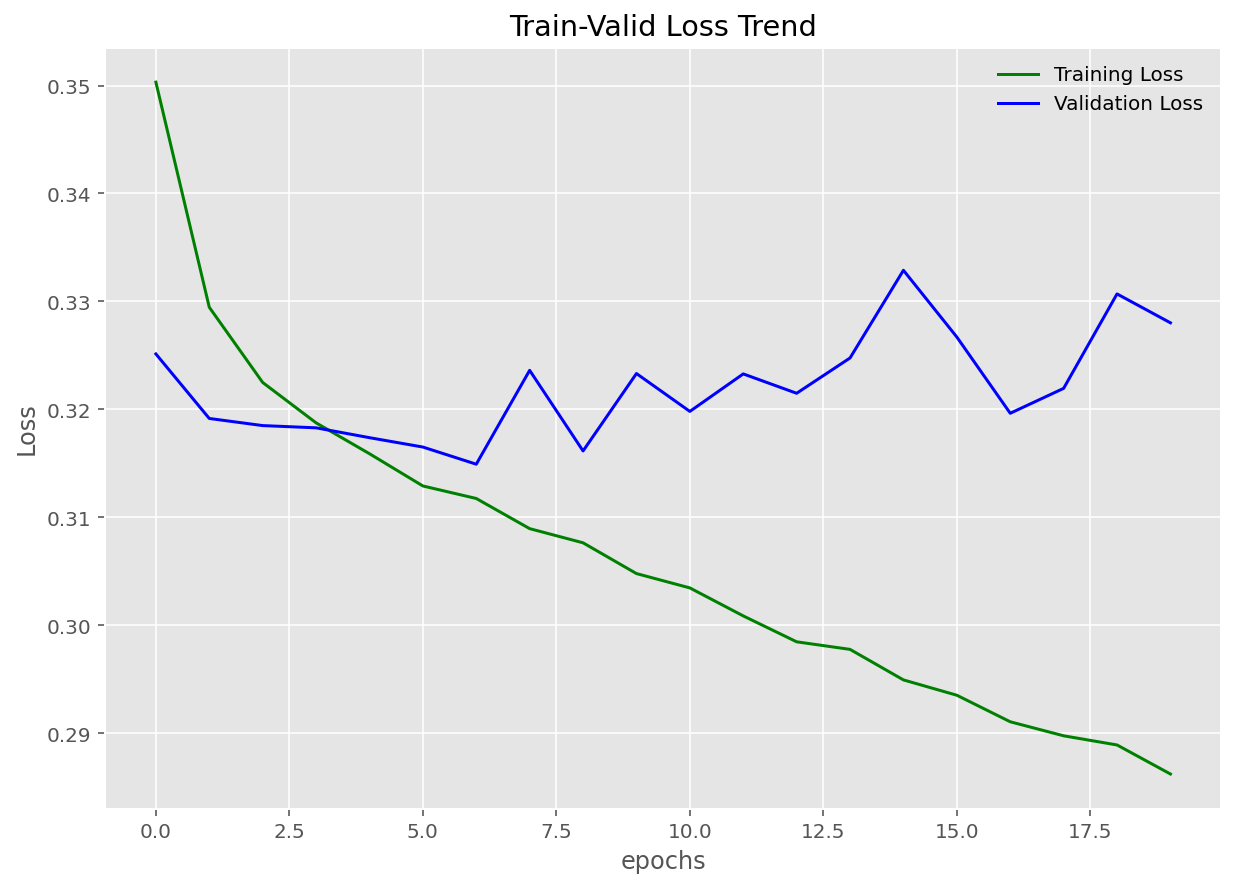

In [54]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print('Loss plot...')

# loss plots
plt.figure(figsize=(10,7))
plt.title("Train-Valid Loss Trend")
plt.plot(train_losses, color='green', label='Training Loss')
plt.plot(valid_losses, color='blue', label='Validation Loss')
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.savefig(saving_path + "loss_plot.png")
plt.show()

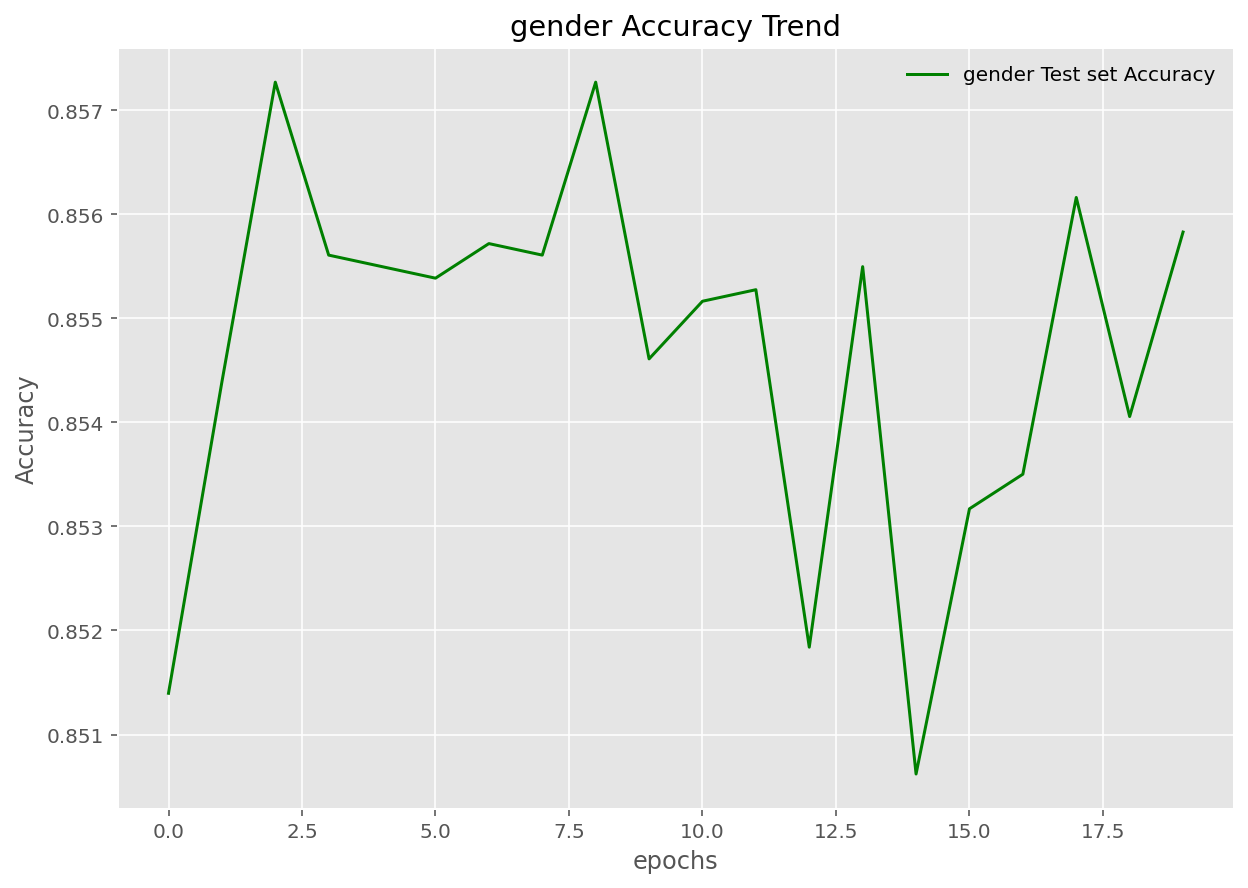

In [55]:
plt.figure(figsize=(10,7))
plt.title("gender Accuracy Trend")
plt.plot(test_y1_acc, color='green', label='gender Test set Accuracy')
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.savefig(saving_path + "accuracy_test_plot.png")
plt.show()

In [56]:
import operator
indexed = list(enumerate(test_y1_acc))
top_5 = sorted(indexed, key=operator.itemgetter(1))[-5:]
print(list(reversed([i for i, v in top_5])))
print(list(reversed([v for i, v in top_5])))

[8, 2, 17, 19, 6]
[0.8572695035460993, 0.8572695035460993, 0.8561613475177305, 0.8558289007092199, 0.855718085106383]
